# XYZ Simulation in XY mode

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

import pulser
from pulser import Pulse, Sequence, Register
from pulser.simulation import Simulation
from pulser.devices import MockDevice
from pulser.waveforms import BlackmanWaveform

Floquet Engineering on two atoms

In [75]:
coords = np.array([[0, 0], [10, 0]])
qubits = dict(enumerate(coords))
reg = Register(qubits)
seq = Sequence(reg, MockDevice)
seq.declare_channel('MW', 'mw_global')
seq.set_magnetic_field(0., 0., 1.)

In [76]:
t_pulse=26
Floquet_X_pulse = Pulse.ConstantDetuning(BlackmanWaveform(t_pulse, np.pi/2.), 0, 0)
Floquet_Y_pulse = Pulse.ConstantDetuning(BlackmanWaveform(t_pulse, np.pi/2.), 0, -np.pi/2)
Floquet_mX_pulse = Pulse.ConstantDetuning(BlackmanWaveform(t_pulse, np.pi/2.), 0, np.pi)
Floquet_mY_pulse = Pulse.ConstantDetuning(BlackmanWaveform(t_pulse, np.pi/2.), 0, np.pi/2)

In [77]:
tc = 300
tau_1 = tau_2 = tau_3 = tc/6.
t_half = t_pulse/2.

In [78]:
seq.delay(900, 'MW')

seq.delay(tau_1-t_half, 'MW')
seq.add(Floquet_X_pulse, 'MW')
seq.delay(tau_2-2*t_half, 'MW')
seq.add(Floquet_mY_pulse, 'MW')
seq.delay(2*tau_3-2*t_half, 'MW')
seq.add(Floquet_Y_pulse, 'MW')
seq.delay(tau_2-2*t_half, 'MW')
seq.add(Floquet_mX_pulse, 'MW')
seq.delay(tau_1-t_half, 'MW')

seq.delay(tau_1-t_half, 'MW')
seq.add(Floquet_X_pulse, 'MW')
seq.delay(tau_2-2*t_half, 'MW')
seq.add(Floquet_mY_pulse, 'MW')
seq.delay(2*tau_3-2*t_half, 'MW')
seq.add(Floquet_Y_pulse, 'MW')
seq.delay(tau_2-2*t_half, 'MW')
seq.add(Floquet_mX_pulse, 'MW')
seq.delay(tau_1-t_half, 'MW')

seq.delay(tau_1-t_half, 'MW')
seq.add(Floquet_X_pulse, 'MW')
seq.delay(tau_2-2*t_half, 'MW')
seq.add(Floquet_mY_pulse, 'MW')
seq.delay(2*tau_3-2*t_half, 'MW')
seq.add(Floquet_Y_pulse, 'MW')
seq.delay(tau_2-2*t_half, 'MW')
seq.add(Floquet_mX_pulse, 'MW')
seq.delay(tau_1-t_half, 'MW')

seq.delay(tau_1-t_half, 'MW')
seq.add(Floquet_X_pulse, 'MW')
seq.delay(tau_2-2*t_half, 'MW')
seq.add(Floquet_mY_pulse, 'MW')
seq.delay(2*tau_3-2*t_half, 'MW')
seq.add(Floquet_Y_pulse, 'MW')
seq.delay(tau_2-2*t_half, 'MW')
seq.add(Floquet_mX_pulse, 'MW')
seq.delay(tau_1-t_half, 'MW')


seq.delay(2*900, 'MW')   
t_list = [0]
for p in range(1, 14):
    t_list.append(0.300*p-0.001)
print(t_list)

[0, 0.299, 0.599, 0.8989999999999999, 1.199, 1.499, 1.799, 2.099, 2.399, 2.699, 2.999, 3.299, 3.5989999999999998, 3.899]


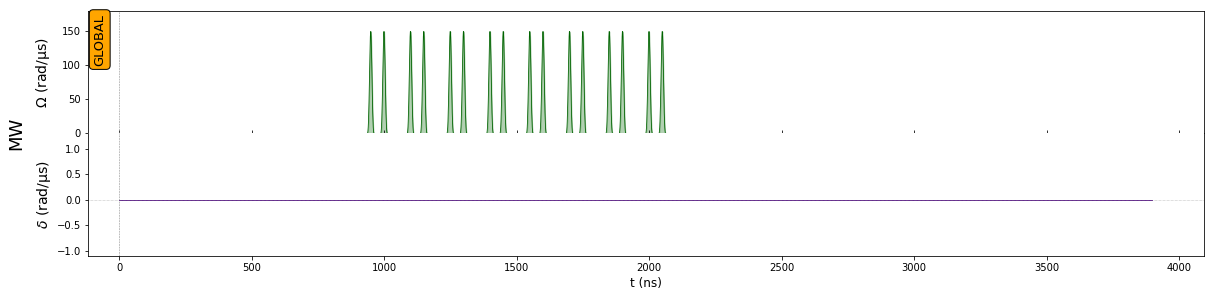

3900

In [79]:
seq.draw()
seq.get_duration()

In [80]:
sim = Simulation(seq, sampling_rate=1.0, config=None, evaluation_times=t_list)

3.899
3.899


In [81]:
psi_y = (qutip.basis(2, 0)+1j*qutip.basis(2, 1)).unit()
sim._initial_state = qutip.tensor(psi_y, psi_y)

In [82]:
res = sim.run()

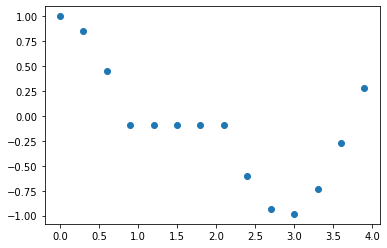

In [89]:
sy = qutip.sigmay()
Id = qutip.qeye(2)
Sigma_y = (qutip.tensor(sy, Id)+qutip.tensor(Id, sy))/2.
plap = res.expect([Sigma_y])

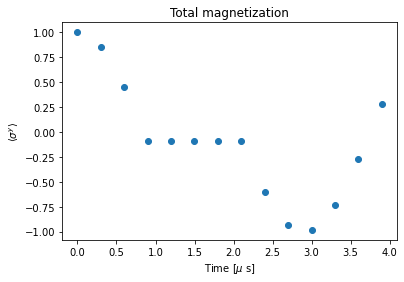

In [94]:
plt.figure()
plt.plot(t_list, plap[0], 'o')
plt.xlabel(r"Time [$\mu$ s]")
plt.ylabel(fr'$ \langle \sigma^y \rangle$')
#plt.axvspan(0, prep_time, alpha=0.06, color='royalblue')
plt.title(fr"Total magnetization")
plt.savefig("Magnetization.pdf")